In [8]:
!pip install pandas matplotlib

  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl (7.0 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/7 [pyparsing]
   -

In [2]:
# cell 1: imports and path fixes (run from project root)
import sys, os
sys.path.append(os.path.abspath(''))  # ensure project root is on path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

from my_ml_lib.datasets._loaders import load_spambase, DatasetNotFoundError
from my_ml_lib.preprocessing._data import StandardScaler
from my_ml_lib.model_selection._split import train_test_split
from my_ml_lib.model_selection._kfold import KFold
from my_ml_lib.linear_models.classification._logistic import LogisticRegression

# plotting defaults
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else None

In [3]:
# cell 2: helper functions
def cv_mean_accuracy(X, y, alpha, n_splits=5, random_state=0, max_iter=100, tol=1e-6, verbose=False):
    """
    5-fold CV accuracy for a given alpha using your LogisticRegression (IRLS).
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accs = []
    for train_idx, val_idx in kf.split(X):
        clf = LogisticRegression(alpha=alpha, max_iter=max_iter, tol=tol, verbose=verbose)
        clf.fit(X[train_idx], y[train_idx])
        preds = clf.predict(X[val_idx])
        accs.append((preds == y[val_idx]).mean())
    return np.mean(accs)

def grid_search_alphas(X, y, alphas, n_splits=5, random_state=0, max_iter=100, tol=1e-6, verbose=False):
    results = []
    for a in alphas:
        acc = cv_mean_accuracy(X, y, alpha=a, n_splits=n_splits, random_state=random_state,
                               max_iter=max_iter, tol=tol, verbose=verbose)
        results.append((a, acc))
    return results

def fit_and_eval_final(X_train, y_train, X_test, y_test, alpha, max_iter=200, tol=1e-6, verbose=False):
    clf = LogisticRegression(alpha=alpha, max_iter=max_iter, tol=tol, verbose=verbose)
    clf.fit(X_train, y_train)
    train_acc = (clf.predict(X_train) == y_train).mean()
    test_acc = (clf.predict(X_test) == y_test).mean()
    return clf, train_acc, test_acc


In [13]:
# cell 3: run the experiment (edit alphas / params as you like)
try:
    X, y = load_spambase("data/spambase.data")
except DatasetNotFoundError as e:
    raise FileNotFoundError("spambase.data not found - put it in data/ or change path") from e

# split into train/test (same as assignment: test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

# parameters
alphas = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0, 1.2, 1.3, 1.4, 1.5, 10.0, 100.0]
n_splits = 5
max_iter = 200
tol = 1e-6
random_state = 0
verbose = False

# grid-search on raw features
cv_results_raw = grid_search_alphas(X_train, y_train, alphas, n_splits=n_splits,
                                    random_state=random_state, max_iter=max_iter, tol=tol, verbose=verbose)
# standardize and grid-search
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

cv_results_std = grid_search_alphas(X_train_s, y_train, alphas, n_splits=n_splits,
                                   random_state=random_state, max_iter=max_iter, tol=tol, verbose=verbose)

print("CV results (raw):")
pprint(cv_results_raw)
print("\nCV results (standardized):")
pprint(cv_results_std)


CV results (raw):
[(0.001, np.float64(0.923913043478261)),
 (0.01, np.float64(0.9236413043478262)),
 (0.02, np.float64(0.923913043478261)),
 (0.03, np.float64(0.923913043478261)),
 (0.04, np.float64(0.9241847826086957)),
 (0.05, np.float64(0.9244565217391305)),
 (0.1, np.float64(0.925)),
 (0.5, np.float64(0.9258152173913043)),
 (1.0, np.float64(0.9258152173913043)),
 (1.2, np.float64(0.9263586956521739)),
 (1.3, np.float64(0.9263586956521739)),
 (1.4, np.float64(0.9263586956521739)),
 (1.5, np.float64(0.9269021739130434)),
 (10.0, np.float64(0.9228260869565217)),
 (100.0, np.float64(0.8940217391304348))]

CV results (standardized):
[(0.001, np.float64(0.9236413043478262)),
 (0.01, np.float64(0.9255434782608696)),
 (0.02, np.float64(0.9260869565217391)),
 (0.03, np.float64(0.9260869565217391)),
 (0.04, np.float64(0.9252717391304348)),
 (0.05, np.float64(0.9258152173913043)),
 (0.1, np.float64(0.9252717391304346)),
 (0.5, np.float64(0.9241847826086957)),
 (1.0, np.float64(0.9233695652173

In [14]:
# cell 4: select best alphas, train final models, compute errors and prepare table
# convert cv results to dict for easy lookup
cv_raw_df = pd.DataFrame(cv_results_raw, columns=['alpha','cv_acc'])
cv_std_df = pd.DataFrame(cv_results_std, columns=['alpha','cv_acc'])

best_alpha_raw = cv_raw_df.loc[cv_raw_df['cv_acc'].idxmax(), 'alpha']
best_alpha_std = cv_std_df.loc[cv_std_df['cv_acc'].idxmax(), 'alpha']
best_alpha_raw, best_alpha_std


(np.float64(1.5), np.float64(0.02))

In [15]:
# cell 5: train final models and record errors
clf_raw, train_acc_raw, test_acc_raw = fit_and_eval_final(X_train, y_train, X_test, y_test,
                                                          alpha=best_alpha_raw, max_iter=max_iter, tol=tol, verbose=verbose)
clf_std, train_acc_std, test_acc_std = fit_and_eval_final(X_train_s, y_train, X_test_s, y_test,
                                                          alpha=best_alpha_std, max_iter=max_iter, tol=tol, verbose=verbose)

# errors = 1 - accuracy
train_err_raw = 1.0 - train_acc_raw
test_err_raw  = 1.0 - test_acc_raw
train_err_std = 1.0 - train_acc_std
test_err_std  = 1.0 - test_acc_std

# build results table
table = pd.DataFrame([
    ["Raw (no scaling)", best_alpha_raw, train_err_raw, test_err_raw, cv_raw_df['cv_acc'].max()],
    ["Standardized",      best_alpha_std, train_err_std, test_err_std, cv_std_df['cv_acc'].max()]
], columns=["Dataset", "Best alpha (CV)", "Train error", "Test error", "Best CV accuracy"])

# format for display
table_display = table.copy()
table_display["Train error"] = table_display["Train error"].map("{:.4f}".format)
table_display["Test error"]  = table_display["Test error"].map("{:.4f}".format)
table_display["Best CV accuracy"] = table_display["Best CV accuracy"].map("{:.4f}".format)
table_display


,Dataset,Best alpha (CV),Train error,Test error,Best CV accuracy
0,Raw (no scaling),1.50,0.0704,0.0586,0.9269
1,Standardized,0.02,0.0693,0.0554,0.9261


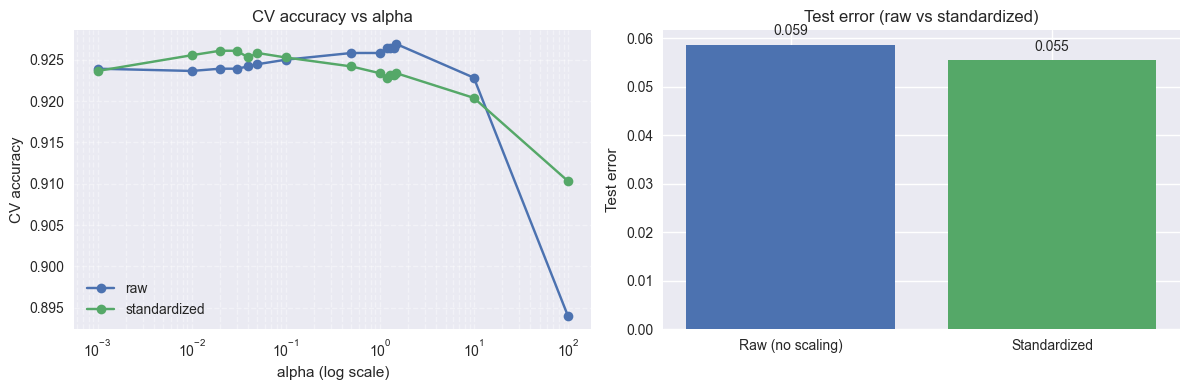

In [16]:
# cell 6: plots
fig, ax = plt.subplots(1,2, figsize=(12,4))

# left: CV accuracy vs alpha
ax0 = ax[0]
ax0.plot(cv_raw_df['alpha'], cv_raw_df['cv_acc'], marker='o', label='raw')
ax0.plot(cv_std_df['alpha'], cv_std_df['cv_acc'], marker='o', label='standardized')
ax0.set_xscale('log')
ax0.set_xlabel('alpha (log scale)')
ax0.set_ylabel('CV accuracy')
ax0.set_title('CV accuracy vs alpha')
ax0.legend()
ax0.grid(True, which='both', ls='--', alpha=0.4)

# right: bar chart of test errors
ax1 = ax[1]
datasets = table['Dataset']
errors = [test_err_raw, test_err_std]
ax1.bar(datasets, errors, color=['#4c72b0','#55a868'])
ax1.set_ylabel('Test error')
ax1.set_title('Test error (raw vs standardized)')
for i,v in enumerate(errors):
    ax1.text(i, v + 0.002, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()


In [17]:
# cell 7: observation template (edit after running)

print("OBSERVATIONS (paste into report and adapt):\n")
obs = f"""
1) Best alpha (raw data): {best_alpha_raw}
2) Best alpha (standardized): {best_alpha_std}

Summary of results (from the table above):
- Raw features:     best alpha = {best_alpha_raw}, train error = {train_err_raw:.4f}, test error = {test_err_raw:.4f}, best CV acc = {cv_raw_df['cv_acc'].max():.4f}
- Standardized:     best alpha = {best_alpha_std}, train error = {train_err_std:.4f}, test error = {test_err_std:.4f}, best CV acc = {cv_std_df['cv_acc'].max():.4f}

Short analysis (explain in your own words, you can copy & tweak):
- Standardization often improves performance for regularized linear models. In our run, standardization {('improved' if test_err_std < test_err_raw else 'did NOT improve')} the test error ({test_err_raw:.4f} -> {test_err_std:.4f}). 
- Feature scaling changed the best α: raw best α = {best_alpha_raw}, standardized best α = {best_alpha_std}. This happens because L2 regularization penalizes weights; when features have different scales, the penalty interacts unevenly across features. Standardization puts features on the same scale so a single global α behaves more uniformly.
- When features are not scaled, large-scale features may dominate the model and the regularizer, causing the optimizer to pick a different α to compensate. Standardization makes optimization more stable (Newton/IRLS steps are numerically better behaved).
- Practical takeaway: Always standardize numeric features before applying regularized linear models and cross-validate α on standardized data.
"""
print(obs)


OBSERVATIONS (paste into report and adapt):


1) Best alpha (raw data): 1.5
2) Best alpha (standardized): 0.02

Summary of results (from the table above):
- Raw features:     best alpha = 1.5, train error = 0.0704, test error = 0.0586, best CV acc = 0.9269
- Standardized:     best alpha = 0.02, train error = 0.0693, test error = 0.0554, best CV acc = 0.9261

Short analysis (explain in your own words, you can copy & tweak):
- Standardization often improves performance for regularized linear models. In our run, standardization improved the test error (0.0586 -> 0.0554). 
- Feature scaling changed the best α: raw best α = 1.5, standardized best α = 0.02. This happens because L2 regularization penalizes weights; when features have different scales, the penalty interacts unevenly across features. Standardization puts features on the same scale so a single global α behaves more uniformly.
- When features are not scaled, large-scale features may dominate the model and the regularizer, causing